# Plotting Points and Lines

<img src="../resources/assets/co2_emissions.png" alt="drawing" width="1000"/>

<img src="../resources/assets/namerica_rivers.jpg"  width="500" height="500">

<img src="../resources/assets/undersea_cables_dark.png" alt="drawing" width="1000"/>

## Plotting Points

Data Source - https://msi.nga.mil/Publications/WPI

- Convert the excel file into a csv and save to the resources folder. 
- Alternatively, there is a ports.csv file in the resources folder with a series of lat/longs placed randomly at the coast. 

In [1]:
import pandas as pd
ports = pd.read_csv("../resources/ports.csv")

In [2]:
print(ports)

             lat         lon
0      19.432680   93.554935
1      54.532050   18.526400
2      40.656520   27.663445
3      50.474590    4.009098
4      28.391250  129.503900
...          ...         ...
19838  37.062715  -79.560240
19839  34.690600  -76.560000
19840  60.094400   24.752800
19841  59.460300   16.318600
19842  29.375600   34.793900

[19843 rows x 2 columns]


In [3]:
from shapely.geometry import Point
import geopandas as gpd

port_geometry = [Point(xy) for xy in zip(ports['lon'], ports['lat'])]
port_geodata = gpd.GeoDataFrame(ports, 
                                crs="EPSG:4326", 
                                geometry=port_geometry)

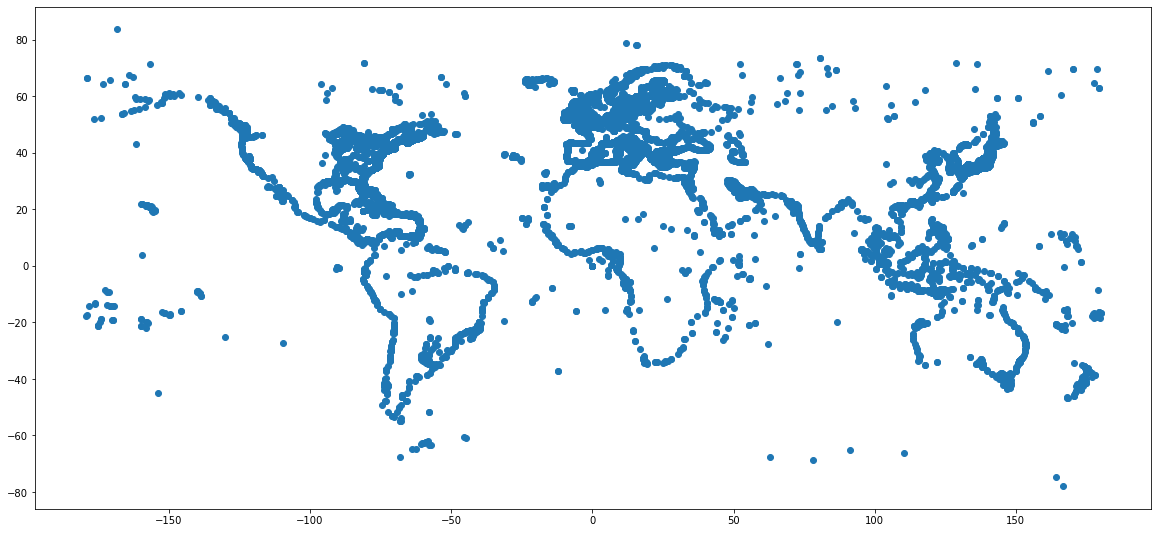

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
port_geodata.plot(ax=ax)
plt.show()

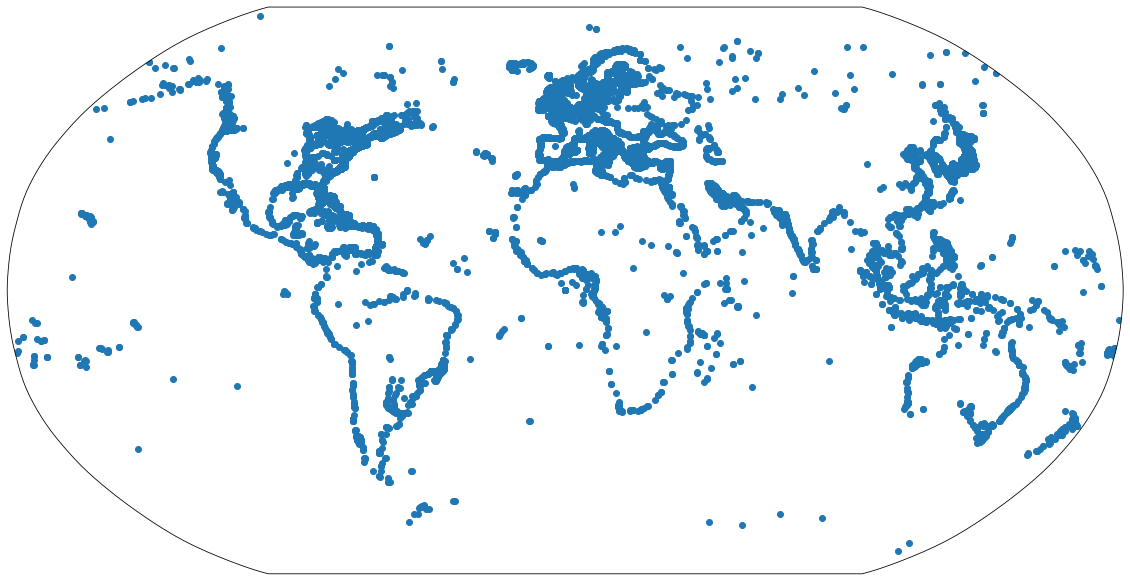

In [5]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
port_geodata.plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

#### Exercise 1 


My attempt

![alt text](../resources/assets/ports.png "Title")


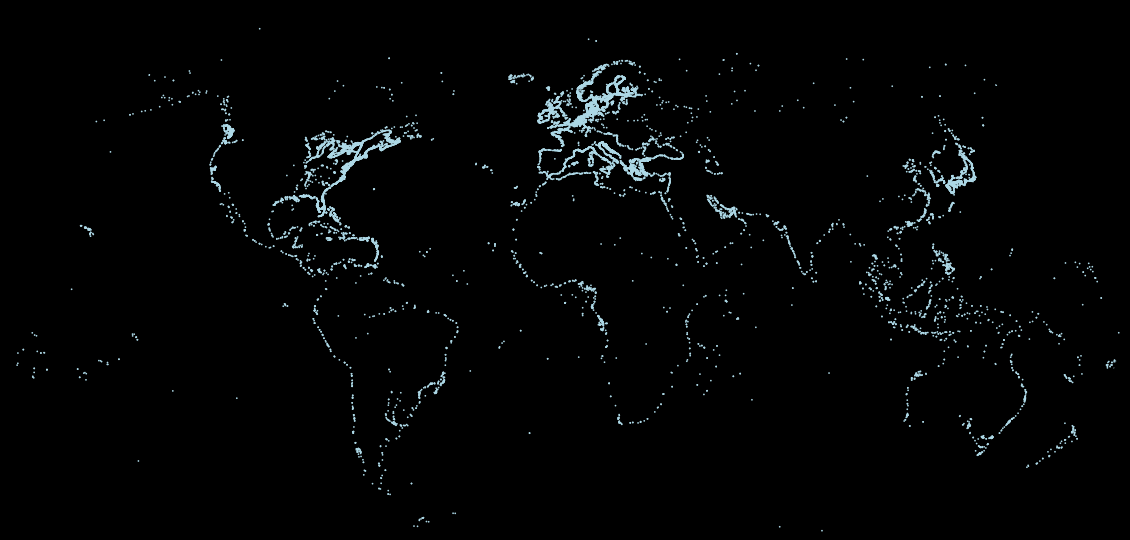

In [6]:
fig, ax = plt.subplots(facecolor='black', 
                       subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
ax.patch.set_facecolor('black')
port_geodata.plot(ax=ax, transform=ccrs.PlateCarree(),
             markersize=3, alpha=1, edgecolors='none', color='lightblue')

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 9000000)
plt.show()

## Plotting Lines

Data Source - https://openflights.org/data.html

- Download airports.dat and place in the resources folder
- Download routes.dat and place in the resources folder

In [7]:
airports = pd.read_csv("../resources/airports", delimiter=',', 
                       names=['id', 'name', 'city', 'country', 'iata', 
                              'icao', 'lat', 'long', 'altitude', 'timezone',
                              'dst', 'tz', 'type', 'source'])

In [8]:
print(airports.columns)

Index(['id', 'name', 'city', 'country', 'iata', 'icao', 'lat', 'long',
       'altitude', 'timezone', 'dst', 'tz', 'type', 'source'],
      dtype='object')


### Exercise

- Create a list of points from the lat/long values in the airports DataFrame
- Convert the airports dataframe to a GeoDataFrame using the list of points created above
- Generate a map of the worlds airports

In [9]:
airport_geometry = [Point(xy) for xy in zip(airports['long'], 
                                            airports['lat'])]
airport_geodata = gpd.GeoDataFrame(airports, 
                                   crs="EPSG:4326", 
                                   geometry=airport_geometry)

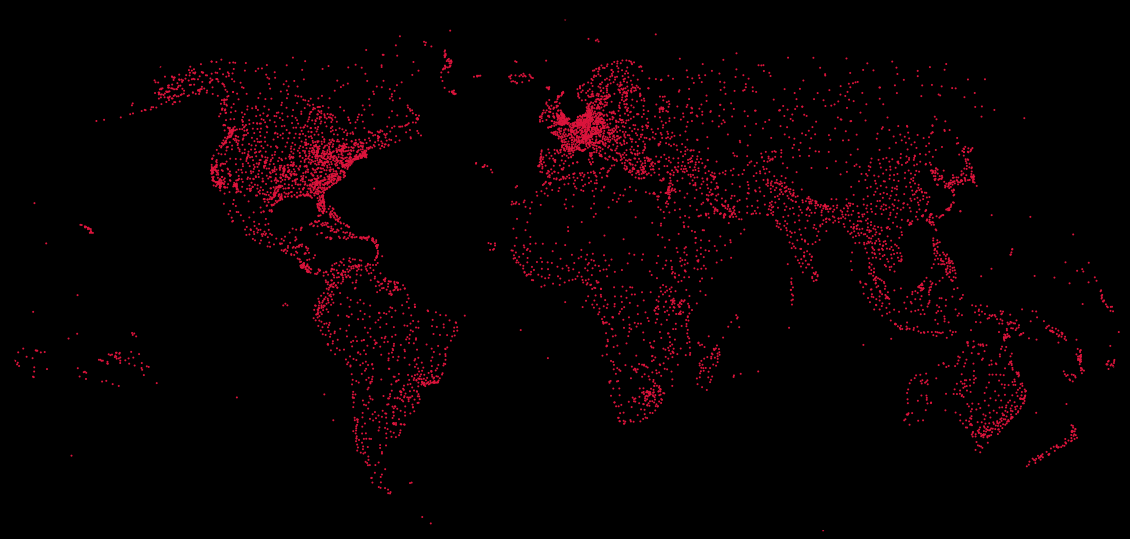

In [10]:
fig, ax = plt.subplots(facecolor='black', 
                       subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
ax.patch.set_facecolor('black')

airport_geodata.plot(ax=ax, transform=ccrs.PlateCarree(), 
                     markersize=4, alpha=1, color='crimson', 
                     edgecolors='none')
plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 9000000)
plt.show()

In [11]:
routes = pd.read_csv("../resources/routes", 
                     delimiter=',', 
                     names=['airline', 'id', 'source_airport', 
                            'source_airport_id', 'destination_airport', 
                            'destination_airport_id', 'codeshare',
                            'stops', 'equitment'])

In [12]:
print(routes.columns)

Index(['airline', 'id', 'source_airport', 'source_airport_id',
       'destination_airport', 'destination_airport_id', 'codeshare', 'stops',
       'equitment'],
      dtype='object')


### Data Manipulation

We want to manipulate our data so that we have a DataFrame of Linestrings joining the source airport to the destination airport for each route. The method that we are going to employ to create LineStrings for each route is as follows.

- Create a duplicate airports DataFrame and label one as source and one as destination.
- Merge the source DataFrame with the routes using the routes source iata code.
- Merge the destination DataFrame with the routes using the routes destination iata code.
- Use the latitude and longitude values of the source and destinations airports which are now merged into the routes DataFrame to create a LineString representing that route.

Below we are duplicating the original airports DataFrame and labelling the columns of one with _source and the other with _destination.

In [13]:
source_airports = airports[['name', 'iata', 'icao', 'lat', 'long']]
destination_airports = source_airports.copy()
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

In [14]:
routes = routes[['source_airport', 'destination_airport']]
routes = pd.merge(routes, 
                  source_airports, 
                  left_on='source_airport', 
                  right_on='iata_source')
routes = pd.merge(routes, 
                  destination_airports, 
                  left_on='destination_airport', 
                  right_on='iata_destination')

In [15]:
print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


In [16]:
from shapely.geometry import LineString

routes_geometry = [LineString([[routes.iloc[i]['long_source'], 
                                routes.iloc[i]['lat_source']], 
                               [routes.iloc[i]['long_destination'], 
                                routes.iloc[i]['lat_destination']]]) 
                   for i in range(routes.shape[0])]

routes_geodata = gpd.GeoDataFrame(routes, 
                                  geometry=routes_geometry, 
                                  crs='EPSG:4326')

In [17]:
print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination', 'geometry'],
      dtype='object')


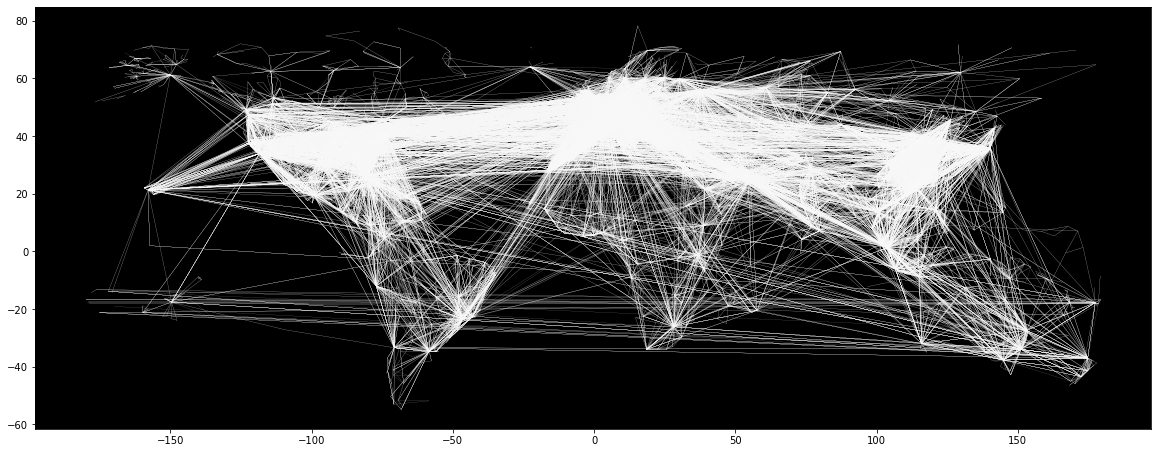

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
ax.patch.set_facecolor('black')

routes_geodata.plot(ax=ax, color='white', linewidth=0.1)

plt.show()

- Cartopy can be used to manipulate the way that lines are plotted. 
- The transform=ccrs.Geodetic() method transforms the LineStrings to account for the earths curvature. 
- I have also changed the projection to the Robinson projection because it is one of the more realistic ways to plot global datasets, accounting for the fact that the earth is not flat. 
- I also have reduced the alpha value to 0.1 to make it a little bit clearer.

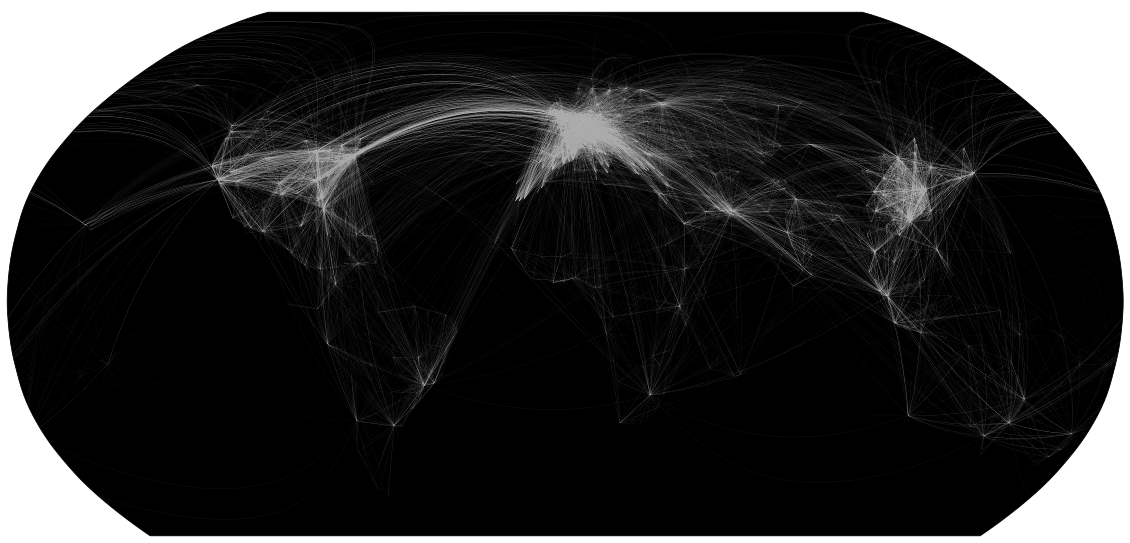

In [19]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
ax.patch.set_facecolor('black')
routes_geodata.plot(ax=ax, 
                    transform=ccrs.Geodetic(), 
                    color='white', 
                    linewidth=0.1, 
                    alpha=0.1)
plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 8800000)
plt.show()

### Exercise 3

- Use the routes data to add a new column to the airports DataFrame with a value showing the number of flights that landed in that airport
- Create a plot combining the routes and airports into one
- Scale the size of the airport points according to the number of flights that land there.
- The expected output is shown below.

![alt text](../resources/assets/airroutes_mad.png "Title")

In [20]:
airport_source_count = routes.source_airport.value_counts()
airport_destination_count = routes.destination_airport.value_counts()

print(airport_source_count)
airport_source_count = pd.DataFrame({'airport':airport_source_count.index, 
                                     'source_airport_count':airport_source_count.values})
airport_destination_count = pd.DataFrame({'airport':airport_destination_count.index, 
                                          'destination_airport_count':airport_destination_count.values})

airport_counts = pd.merge(airport_source_count, 
                          airport_destination_count, 
                          left_on="airport", 
                          right_on="airport")


ATL    915
ORD    558
LHR    527
PEK    525
CDG    524
      ... 
EAT      1
TGR      1
YKM      1
BTM      1
YPO      1
Name: source_airport, Length: 3241, dtype: int64


In [21]:
airport_counts['count'] = airport_counts['source_airport_count'] + airport_counts['destination_airport_count'] 

airport_counts = pd.merge(airport_counts, 
                          airports, 
                          left_on="airport", 
                          right_on="iata")

geometry = [Point(xy) for xy in zip(airport_counts.long, 
                                    airport_counts.lat)]

airport_counts = gpd.GeoDataFrame(airport_counts, 
                                  geometry=geometry, 
                                  crs="EPSG:4326")

airport_counts['markersize'] = airport_counts['count'] / 10

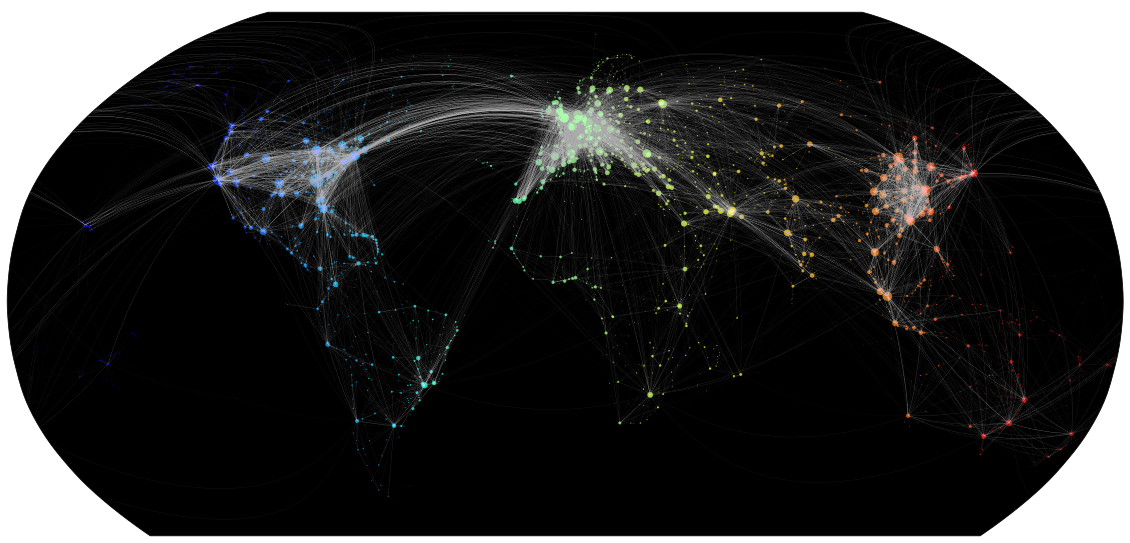

In [22]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
ax.patch.set_facecolor('black')
routes_geodata.plot(ax=ax, 
                    transform=ccrs.Geodetic(), 
                    color='white', 
                    linewidth=0.1, 
                    alpha=0.1)
airport_counts.plot(ax=ax, 
                    transform=ccrs.PlateCarree(), 
                    markersize=airport_counts['markersize'], 
                    alpha=0.8, 
                    column=airport_counts['long'], 
                    cmap='jet', 
                    edgecolors='none')

plt.setp(ax.spines.values(), color='#090909')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#090909')
ax.set_ylim(-7000000, 8800000)
plt.show()